In [1]:
import pandas as pd
from nonconformist.icp import IcpClassifier
from nonconformist.nc import NcFactory, InverseProbabilityErrFunc
import numpy as np
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from nonconformist.acp import RandomSubSampler, AggregatedCp
import matplotlib.pyplot as plt
import seaborn as sns

from utils import get_chembl_drugs_with_descriptors, COLOUR_B3DB, COLOUR_CNSDB, COLOUR_CHEMBL, COLOUR_POSITIVE, COLOUR_NEGATIVE


def cp_ensembl_predict_significance(cp_ensemble, X):
    return pd.DataFrame(np.mean([mod.predict(X) for mod in cp_ensemble], axis=0))


def cp_ensemble_predict_efficient_single_classification(cp_ensemble, X, significance):
    """
    Given an ensemble of conformal predictors, predict one-class efficient classification i.e. only return a class label if a single class is predicted under a particular significance level. Return no prediction if no or multiple classes are predicted.     
    """
    p_vals = cp_ensembl_predict_significance(cp_ensemble, X)
    return p_vals.apply(axis=1, func=lambda x: 0 if (x[0] >= significance > x[1]) else 1 if (x[1] >= significance > x[0]) else None)

df_chembl_drugs = get_chembl_drugs_with_descriptors()
df_chembl_drugs = df_chembl_drugs.loc[:,~df_chembl_drugs.columns.duplicated()].copy() # Drop duplicate columns.
print(f"Read {len(df_chembl_drugs)} ChEMBL drugs.")
df_b3db_kc = pd.read_csv("b3db_kc_split_descriptors.tsv", sep="\t")
df_b3db_kc['BBB_numeric'] = df_b3db_kc['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
print(f"Read {len(df_b3db_kc)} B3DB KC records.")

[13:46:44] Initializing Normalizer
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.n

Read 3957 ChEMBL drugs.
Read 3322 B3DB KC records.


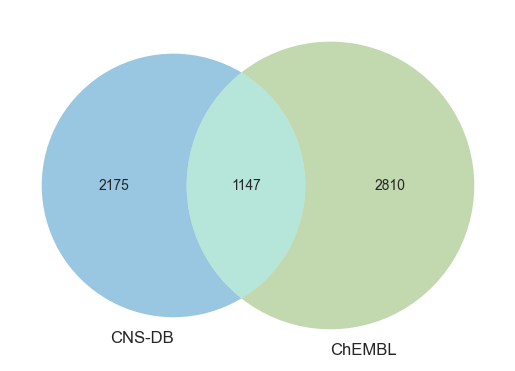

In [10]:
from matplotlib_venn import venn2
venn2((
    set(df_b3db_kc.smiles),
    set(df_chembl_drugs.canonical_smiles)), ["CNS-DB", "ChEMBL"], set_colors=[COLOUR_CNSDB, COLOUR_CHEMBL])


In [11]:
_model = RandomForestClassifier(n_estimators=90, max_depth=20, random_state=42)

icp_classifier_condition = (lambda instance: instance[1]) # Mondrian condition in conformal prediction
acp_aggregation_function = (lambda x: np.median(x, axis=2)) # Function to aggregate p-values in ACP

def train_acp_cv(data_X, class_y, data_groups, acp_model_count, normaliser_model=None, acp_option=None, cv_n_splits=5):
    if acp_option is None:
        acp_option = RandomSubSampler(calibration_portion=0.3)
 
    kf = StratifiedGroupKFold(n_splits=cv_n_splits, random_state=42, shuffle=True)
    acps_cv = []
    
    for i, (train_index, test_index) in enumerate(kf.split(data_X, class_y, data_groups)):
        print(f"Fold {i}, #training: {len(train_index)}, #test {len(test_index)}")
        X_train, X_test = data_X[train_index], data_X[test_index]
        y_train, y_test = class_y[train_index], class_y[test_index]
        
        mod = clone(_model)
        nc = NcFactory.create_nc(mod, err_func=InverseProbabilityErrFunc(), normalizer_model=normaliser_model)
        icp = IcpClassifier(nc, condition=icp_classifier_condition)
        acp = AggregatedCp(n_models=acp_model_count, predictor=icp, sampler=acp_option,
                           aggregation_func=acp_aggregation_function)
        acp.fit(X_train, y_train)
        
        acps_cv.append(acp)
    
    return acps_cv

np.random.seed(42)
features = SIMPLE_FILTERED_FEATURES = [
    'desc2D_TPSA',
    'desc2D_NumHDonors',
    'desc2D_MolWt',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_HeavyAtomCount',
    'desc2D_MinPartialCharge',
    'desc2D_MaxPartialCharge',
    'desc2D_qed',
    'desc2D_MinEStateIndex',
    'desc2D_HallKierAlpha',
    'desc2D_Kappa3',
    'desc2D_Ipc',
    'desc2D_FractionCSP3',
    'desc2D_MinAbsEStateIndex',
    'desc2D_MaxAbsEStateIndex',
    'desc2D_NumRotatableBonds',
    'desc2D_NumAliphaticHeterocycles',
    'desc2D_NumSaturatedCarbocycles',
    'desc2D_BalabanJ',
    'desc2D_NumSpiroAtoms',
    'desc2D_NumAtomStereoCenters',
    'desc2D_NumBridgeheadAtoms',
    'desc2D_NumUnspecifiedAtomStereoCenters',
    'desc2D_NumRadicalElectrons',
    'desc2D_SPS',
] + [fn for fn in list(df_b3db_kc) if fn.startswith("maccs")]
acp_ensemble = train_acp_cv(df_b3db_kc[features].to_numpy(), df_b3db_kc["BBB_numeric"].to_numpy(), df_b3db_kc["murcko_scaffold_grouped"].to_numpy(), acp_model_count=25)

Fold 0, #training: 2581, #test 741
Fold 1, #training: 2732, #test 590
Fold 2, #training: 2661, #test 661
Fold 3, #training: 2678, #test 644
Fold 4, #training: 2636, #test 686


In [13]:
df_b3db_kc.split.value_counts()

split
training    2677
test         645
Name: count, dtype: int64

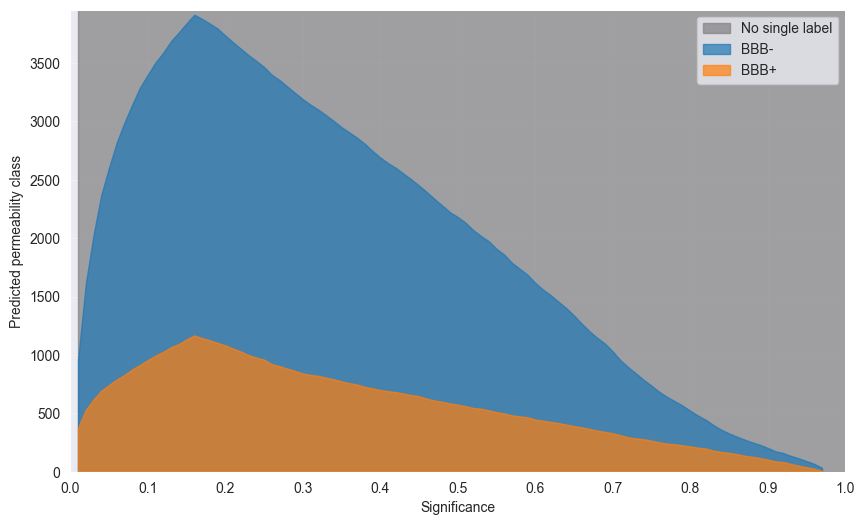

In [32]:
pred_by_sig = []
for i in range(1, 101):
    significance = i / 100
    chembl_predicted = cp_ensemble_predict_efficient_single_classification(acp_ensemble, df_chembl_drugs.head(100000)[features].to_numpy(), significance=significance)
    pred_by_sig.append( {"significance": significance} | {k if pd.notna(k) else "undefined": v for k, v in dict(chembl_predicted.value_counts(dropna=False)).items()})
_df = pd.DataFrame(pred_by_sig)
_total = _df.iloc[-1]["undefined"]
_df["cumsum_positive"] = _df[1]
_df["cumsum_positive_negative"] = _df[0] + _df[1]
_df["total"] = _total

plt.figure(figsize=(10, 6))
plt.fill_between(_df['significance'], 0, _df['total'], color=COLOUR_GRAY, label='No single label', alpha=0.7)
plt.fill_between(_df['significance'], 0, _df['cumsum_positive_negative'], color=COLOUR_NEGATIVE, label='BBB-', alpha=0.7)
plt.fill_between(_df['significance'], 0, _df['cumsum_positive'], color=COLOUR_POSITIVE, label='BBB+', alpha=0.7)

plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.xlabel('Significance')
plt.ylabel('Predicted permeability class')
plt.ylim(0, _total)
plt.xlim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/figure_12.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
for i in range(1, 8):
    _sig = i/10
    df_chembl_drugs[f"pred_sig_{_sig}"] = cp_ensemble_predict_efficient_single_classification(acp_ensemble, df_chembl_drugs[features].to_numpy(), significance=_sig).apply(lambda x: x if pd.notna(x) else "Undefined")

In [14]:
_df = df_chembl_drugs[df_chembl_drugs.indication_class_normalised.apply(len) > 0]
print(f"{len(_df)} drugs with normalised class")
_df = _df.explode(["indication_class_normalised"]) 
print(f"{len(_df)} molecule-indication class links")
print(f"A total of {_df.indication_class_normalised.nunique()} indication classes")
_icc = _df.indication_class_normalised.value_counts()
_min_drugs = 20
_ind = _icc[_icc >= _min_drugs]  # This is sorted in descending order
_df = _df[_df.indication_class_normalised.apply(lambda x: x in _ind)]
print(f"{len(_ind)} indication classes with more than {_min_drugs} molecules, with a total of {len(_df)} molecule-indication class links")
_df["indication_class_total"] = _df["indication_class_normalised"].apply(lambda x: _ind[x])

1771 drugs with normalised class
2093 molecule-indication class links
A total of 190 indication classes
31 indication classes with more than 20 molecules, with a total of 1435 molecule-indication class links


In [19]:
# TODO antiparkinsonians need review, Levodopa is predicted as negative.
_z = []
for ii in [2, 4, 6]:
    _sig = ii/10    
    print(_sig)
    for _i in list(_df[_df.pred_sig==0.4].sort_values(by="positive_norm", ascending=False).indication_class_normalised): #_ind.index:
        if _i in {"Vitamin", "Diagnostic Aid", "Pharmaceutic Aid", "Antiparkinsonian"}: # Exclude some classes
            continue
        _dfi = _df[_df.indication_class_normalised == _i]
        _iv = {
            "significance": _sig,
            "indication_class_normalised": _i, 
            "count": _ind[_i], 
            "positive_norm":  sum(_dfi[f"pred_sig_{_sig}"] == 1) / len(_dfi),
            "negative_norm":  sum(_dfi[f"pred_sig_{_sig}"] == 0) / len(_dfi),
            "total": 1,
        }
        _iv["cumsum_positive"] = _iv["positive_norm"]
        _iv["cumsum_positive_negative"] = _iv["positive_norm"] + _iv["negative_norm"]
        _z.append(_iv)
__df = pd.DataFrame(_z)

plt.figure(figsize=(6, 14))
sns.barplot(__df, x='total', y="indication_class_normalised",  hue='significance', palette='dark:gray', alpha=0.7)
sns.barplot(__df, x='cumsum_positive_negative', y="indication_class_normalised",  hue='significance', palette='dark:blue', alpha=0.7)
sns.barplot(__df, x='cumsum_positive', y="indication_class_normalised",  hue='significance', palette='dark:orange', alpha=0.7)
plt.legend().remove() 
plt.xlabel('Compound prediction')
plt.xlim(0, 1)
_ = plt.title("Predicted drug BBB permeability by indication class\n at significance levels of 0.2, 0.4 and 0.6", pad=15)

0.2


AttributeError: 'DataFrame' object has no attribute 'pred_sig'

In [18]:
_df.columns

Index(['chembl_id', 'pref_name', 'molecule_type', 'therapeutic_flag',
       'max_phase', 'indication_class', 'indication_class.1', 'oral',
       'topical', 'prodrug',
       ...
       'maccs_fp_165', 'maccs_fp_166', 'pred_sig_0.1', 'pred_sig_0.2',
       'pred_sig_0.3', 'pred_sig_0.4', 'pred_sig_0.5', 'pred_sig_0.6',
       'pred_sig_0.7', 'indication_class_total'],
      dtype='object', length=2413)

[]

In [172]:
df_chembl_drugs.indication_class_normalised.explode().value_counts()

indication_class_normalised
Antibacterial                               206
Antihypertensive                             94
Antineoplastic                               91
Analgesic                                    74
Anti-Inflammatory                            58
                                           ... 
Multiple Sclerosis Symptomatic Treatment      1
Anterior Pituitary Suppressant                1
Hypoglycemic                                  1
Antihypercalcemic                             1
Synovitis Agent                               1
Name: count, Length: 190, dtype: int64

In [3]:
## Extend to include all phase 1+components
from utils import get_chembl_small_molecules_with_descriptors

df_chembl_investigational = get_chembl_small_molecules_with_descriptors(min_max_phase=-1)
print(f"Read {len(df_chembl_investigational)} ChEMBL molecules.")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
[16:31:34] Can't kekulize mol.  Unkekulized atoms: 3 5
[16:31:34] Can't kekulize mol.  Unkekulized atoms: 3 5
[16:31:36] Can't kekulize mol.  Unkekulized atoms: 3 10
[16:31:36] Can't kekulize mol.  Unkekulized atoms: 3 10
[16:31:38] Can't kekulize mol.  Unkekulized atoms: 3 5
[16:31:38] Can't kekulize mol.  Unkekulized atoms: 3 5
[16:31:38] Can't kekulize mol.  Unkekulized atoms: 3 5
[16:31:38] Can't kekulize mol.  Unkekulized atoms: 3 5
[16:31:38] Can't kekulize mol.  Unkekulized atoms: 3 13
[16:31:38] Can't kekulize mol.  Unkekulized atoms: 3 13
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.n

Read 13048 ChEMBL molecules.


In [152]:
for i in range(1, 8):
    _sig = i/10
    df_chembl_investigational[f"pred_sig_{_sig}"] = cp_ensemble_predict_efficient_single_classification(acp_ensemble, df_chembl_investigational[features].to_numpy(), significance=_sig).apply(lambda x: x if pd.notna(x) else "Undefined")

In [166]:
_to = "chembl_34_investigational_cp_bbb_permeability.csv"
df_chembl_investigational[["chembl_id"] + [c for c in list(df_chembl_investigational) if c.startswith("pred_sig")]].to_csv(_to, index=False)
print(f"Saved {len(df_chembl_investigational)} ChEMBL investigational compound predictions to {_to}")

Saved 13048 ChEMBL investigational compound predictions to chembl_34_investigational_cp_bbb_permeability.csv


In [115]:
df_b3db_kc[df_b3db_kc["names"].apply(lambda x: pd.notna(x) and "levodopa" in x.lower())]

,inchi,names,iupac_name,smiles,cid,record_ids,logBB,logBB_group,BBB+/BBB-,BBB+/BBB-_group,...,cats2D_RR.bins-1,cats2D_RR.bins-2,cats2D_RR.bins-3,cats2D_RR.bins-4,cats2D_RR.bins-5,cats2D_RR.bins-6,cats2D_RR.bins-7,cats2D_RR.bins-8,murcko_scaffold_grouped,BBB_numeric
3218,InChI=1S/C9H11NO4/c10-6(9(13)14)3-5-1-2-7(11)8...,Levodopa,"(2S)-2-amino-3-(3,4-dihydroxyphenyl)propanoic ...",N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,6047.0,R5_guerra_2008:58|R6_adenot_2004:41|R6_adenot_...,-0.78,B,BBB+,A,...,12.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,c1ccc(CCOC2CCCCC2N2CCCC2)cc1,1


In [117]:
df_chembl_drugs[["pref_name", "indication_class", "indication_class_normalised", "canonical_smiles"]]

,pref_name,indication_class,indication_class_normalised,canonical_smiles
0,PRAZOSIN,Antihypertensive,[Antihypertensive],COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC
1,NICOTINE,Smoking Cessation Adjunct,[Smoking Cessation Adjunct],CN1CCC[C@H]1c1cccnc1
2,OFLOXACIN,Antibacterial,[Antibacterial],CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
3,NALIDIXIC ACID,Antibacterial,[Antibacterial],CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21
4,DARAPLADIB,0,[],CCN(CC)CCN(Cc1ccc(-c2ccc(C(F)(F)F)cc2)cc1)C(=O...
...,...,...,...,...
4147,ILOPROST TROMETHAMINE,0,[],CC#CCC(C)[C@H](O)/C=C/[C@@H]1[C@H]2C/C(=C/CCCC...
4148,UPADACITINIB HEMIHYDRATE,0,[],CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...
4149,TECOVIRIMAT MONOHYDRATE,0,[],O.O=C(NN1C(=O)[C@@H]2[C@@H]3C=C[C@@H]([C@H]4C[...
4151,LEVOFLOXACIN,0,[],C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...


## Student data predictions

In [61]:
from b3db_kc.utils import chembl_parent_from_smiles

bacterial = pd.read_csv("students/bacterial.txt", sep="\t", names=["smiles", "name"])
viral = pd.read_csv("students/viral.txt", sep="\t", names=["smiles", "name"])

drug_to_chembl_remapping = {
    # Bacterial
    "Ceftriaxone": "CO/N=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc(=O)c(O)nn3C)CS[C@H]12)c1csc(N)n1",
    "Colistin": "CCC(C)CCCC(=O)N[C@@H](CCN)C(=O)N[C@H](C(=O)N[C@@H](CCN)C(=O)N[C@H]1CCNC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCN)NC(=O)[C@H](CCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](CCN)NC1=O)[C@@H](C)O",
    "Daptomycin": "CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H]1C(=O)NCC(=O)N[C@@H](CCCN)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C)C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@H](CO)C(=O)N[C@@H]([C@H](C)CC(=O)O)C(=O)N[C@@H](CC(=O)c2ccccc2N)C(=O)O[C@@H]1C",
    # Viral
    "doxycycline": "C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@@H]3[C@@H](O)[C@@H]21",
    "valacyclovir": "CC(C)[C@H](N)C(=O)OCCOCn1cnc2c(=O)nc(N)[nH]c21",  # ChEMBL and Drugbank have this form, Wiki and PubChem - the other.
    "Ledipasvir": "COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2ccc3c(c2)C(F)(F)c2cc(-c4ccc5[nH]c([C@@H]6[C@H]7CC[C@H](C7)N6C(=O)[C@@H](NC(=O)OC)C(C)C)nc5c4)ccc2-3)c[nH]1)C(C)C",
    "Velpatasvir": "COC[C@H]1C[C@@H](c2nc(-c3ccc4c(c3)COc3cc5c(ccc6nc([C@@H]7CC[C@H](C)N7C(=O)[C@@H](NC(=O)OC)C(C)C)[nH]c65)cc3-4)c[nH]2)N(C(=O)[C@H](NC(=O)OC)c2ccccc2)C1",
    "Pibrentasvir": "COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc2cc([C@H]3CC[C@H](c4cc5nc([C@@H]6CCCN6C(=O)[C@@H](NC(=O)OC)[C@@H](C)OC)[nH]c5cc4F)N3c3cc(F)c(N4CCC(c5ccc(F)cc5)CC4)c(F)c3)c(F)cc2[nH]1)[C@@H](C)OC",
    "Elbasvir": "COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2)O[C@@H](c2ccccc2)n2c-3cc3cc(-c4c[nH]c([C@@H]5CCCN5C(=O)[C@@H](NC(=O)OC)C(C)C)n4)ccc32)c[nH]1)C(C)C",
}



viral["smiles_normalised"] = viral.apply(axis=1, func=lambda x: chembl_parent_from_smiles(x.smiles)[0] if x["name"] not in drug_to_chembl_remapping else drug_to_chembl_remapping[x["name"]])
bacterial["smiles_normalised"] = bacterial.apply(axis=1, func=lambda x: chembl_parent_from_smiles(x.smiles)[0] if x["name"] not in drug_to_chembl_remapping else drug_to_chembl_remapping[x["name"]])
#viral["smiles_normalised"] = viral.smiles.apply(lambda x: chembl_parent_from_smiles(x)[0])
#bacterial["name"].apply(lambda x: x in drug_to_chembl_remapping)
viral

,smiles,name,smiles_normalised
0,C[C@@H]1[C@H]2[C@@H]([C@H]3[C@@H](C(=O)C(=C([C...,doxycycline,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...
1,CO/N=C(/C1=CC=CO1)\C(=O)N[C@H]2[C@@H]3N(C2=O)C...,cefuroxime,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(N)...
2,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...,Amoxicillin,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...
3,CN1C(=NC(=O)C(=O)N1)SCC2=C(N3[C@@H]([C@@H](C3=...,Ceftriaxone,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...
4,C1=NC2=C(N1COCCO)N=C(NC2=O)N,acyclovir,Nc1nc2c(ncn2COCCO)c(=O)[nH]1
5,CC(C)[C@@H](C(=O)OCCOCN1C=NC2=C1N=C(NC2=O)N)N,valacyclovir,CC(C)[C@H](N)C(=O)OCCOCn1cnc2c(=O)nc(N)[nH]c21
6,C1=NC2=C(N1COC(CO)CO)N=C(NC2=O)N,Ganciclovir,Nc1nc2c(ncn2COC(CO)CO)c(=O)[nH]1
7,C(=O)(O)P(=O)(O)O,Foscarnet,O=C(O)P(=O)(O)O
8,COC1=C(C=C(C=C1)C(F)(F)F)N2[C@H](C3=C(C(=CC=C3...,Letermovir,COc1cccc(N2CCN(C3=Nc4c(F)cccc4[C@H](CC(=O)O)N3...
9,CC(C)NC1=NC2=CC(=C(C=C2N1[C@@H]3[C@H]([C@H]([C...,Maribavir,CC(C)Nc1nc2cc(Cl)c(Cl)cc2n1[C@H]1O[C@@H](CO)[C...


In [8]:
from b3db_kc.utils import smiles_to_mol
from pathlib import Path

_df_chembl_molecule_properties = pd.read_csv("../data/ChEMBL/chembl_molecule_properties.csv.gz", low_memory=False)

# _df["mol"] = _df.canonical_smiles.apply(lambda x: smiles_to_mol(x))
# _n_pre_removal = len(_df)
# _df = _df[_df.mol.apply(Descriptors.ExactMolWt) >= 50]
# _df = _df[_df.mol.apply(Descriptors.ExactMolWt) <= 1000]
# _df["indication_class_normalised"] = _df.indication_class.apply(normalise_chembl_indication_class)
# return _df
#
# def get_chembl_small_molecules_with_descriptors(min_max_phase=0, descriptors=["desc2D", "ecfp-count", "maccs"]):
#     df = get_chembl_drugs_with_descriptors()
#     df = df.rename(columns={
#         "cx_logd": "chemaxon_logd",
#         "cx_logp": "chemaxon_logp",
#         "cx_most_bpka": "chemaxon_pka_b",
#     })
#     with datamol.without_rdkit_log():
#         for dt in descriptors:
#             tr = FPVecTransformer(kind=dt, dtype=float, n_jobs=16, verbose=False)
#             _d = pd.DataFrame(tr(df["mol"]), columns=[f"{dt}_{c}" for c in tr.columns])
#             df = df.join(_d)
#     _pre_removal = len(df)
#     df = df[pd.notna(df["chemaxon_logd"])]
#     print(f"Discarded {_pre_removal - len(df)} molecules without logD or logP specified. {len(df)} remaining.")
#     print(
#         f"Imputing {sum(pd.isna(df.chemaxon_pka_b))} missing most basic group pKa with 0. Used here to allow data exploration as some of the algorithms cannot work on missing values.")
#     df = df.fillna(0)
#     return df[features]
#


In [60]:
from rdkit import Chem
_df_chembl_molecule_properties[_df_chembl_molecule_properties.pref_name == "Elbasvir".upper()].canonical_smiles.iloc[0]


'COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2)O[C@@H](c2ccccc2)n2c-3cc3cc(-c4c[nH]c([C@@H]5CCCN5C(=O)[C@@H](NC(=O)OC)C(C)C)n4)ccc32)c[nH]1)C(C)C'

,inchi,names,iupac_name,smiles,cid,record_ids,logBB,logBB_group,BBB+/BBB-,BBB+/BBB-_group,...,cats2D_RR.bins-1,cats2D_RR.bins-2,cats2D_RR.bins-3,cats2D_RR.bins-4,cats2D_RR.bins-5,cats2D_RR.bins-6,cats2D_RR.bins-7,cats2D_RR.bins-8,murcko_scaffold_grouped,BBB_numeric
0,InChI=1S/Ar,Argon,argon,[Ar],23968.0,R3_abraham_2006:1|R12_garg_2006:24|R21_muehlba...,0.03,B,BBB+,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1ccccc1_group_56,1
1,InChI=1S/C10H10BrNO2/c1-10(2)7-5-6(11)3-4-8(7)...,Brofoxine,"6-bromo-4,4-dimethyl-1H-3,1-benzoxazin-2-one",CC1(C)OC(=O)Nc2ccc(Br)cc21,30630.0,R6_adenot_2004:481,NaN,NaN,BBB+,C,...,12.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,c1cc[nH+]cc1,1
2,InChI=1S/C10H10Cl2N2O/c11-8-2-1-7(5-9(8)12)15-...,Fenmetozole,"2-[(3,4-dichlorophenoxy)methyl]-4,5-dihydro-1H...",Clc1ccc(OCC2=NCCN2)cc1Cl,32049.0,R6_adenot_2004:542,NaN,NaN,BBB+,C,...,12.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,N=C1C=C2CCC3C4CCCC4CCC3C2CC1,1
3,InChI=1S/C10H10ClNO2/c11-6-5-9-12-10(13)7-3-1-...,Chlorthenoxazine,"2-(2-chloroethyl)-2,3-dihydro-1,3-benzoxazin-4...",O=C1NC(CCCl)Oc2ccccc21,8602.0,R6_adenot_2004:1547,NaN,NaN,BBB+,C,...,12.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,O=C(c1ccccc1)N(CCN1CCN(c2ccccc2)CC1)c1ccccn1,1
4,InChI=1S/C10H10FN3S/c1-13-9(12-14(2)10(13)15)7...,Suritozole,"5-(3-fluorophenyl)-2,4-dimethyl-1,2,4-triazole...",Cn1nc(-c2cccc(F)c2)n(C)c1=S,25431.0,R6_adenot_2004:573,NaN,NaN,BBB+,C,...,24.0,30.0,22.0,18.0,12.0,4.0,0.0,0.0,_group_64,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,InChI=1S/N2/c1-2,Nitrogen,molecular nitrogen,N#N,947.0,R12_garg_2006:121|R21_muehlbacher_2011:14|R22_...,0.03,B,BBB+,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1ccccc1_group_85,1
3318,InChI=1S/N2O/c1-2-3,Nitrous Oxide|Nitrous-Oxide,nitrous oxide,[N-]=[N+]=O,948.0,R3_abraham_2006:7|R6_adenot_2004:944|R21_muehl...,0.03,B,BBB+,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1ccc(C(c2ccccc2)N2CCNCC2)cc1,1
3319,InChI=1S/Ne,Neon,neon,[Ne],23935.0,R3_abraham_2006:3|R12_garg_2006:119|R21_muehlb...,0.20,B,BBB+,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1ccc2c(c1)Sc1cccnc1N2CCCN1CCNCC1,1
3320,InChI=1S/Rn,Radon|Thoron,radon,[Rn],24857.0,R3_abraham_2006:4|R21_muehlbacher_2011:259|R40...,-0.12,B,BBB+,A,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=S(Cc1ccccn1)c1nc2ccccc2[nH]1,1


In [103]:
from molfeat.trans import FPVecTransformer
import datamol


def predict_from_dataframe(df):
    df = df.merge(_df_chembl_molecule_properties, left_on="smiles_normalised", right_on="canonical_smiles", how="left").rename(columns={
            "cx_logd": "chemaxon_logd",
            "cx_logp": "chemaxon_logp",
            "cx_most_bpka": "chemaxon_pka_b",
         })
    assert sum(df.pref_name.isna()) == 0, "Compounds not found in ChEMBL"
    df = df.merge(df_b3db_kc[["smiles", "record_ids", "BBB+/BBB-"]].rename(columns={"smiles": "smiles_b3db", "record_ids": "found_in", "BBB+/BBB-": "known_BBB+/BBB-"}), left_on="smiles_normalised", right_on="smiles_b3db", how="left").drop(columns=["smiles_b3db"])
    df["mol"] = df["smiles_normalised"].apply(lambda x: Chem.MolFromSmiles(x))
    with datamol.without_rdkit_log():
        for dt in ["desc2D",  "maccs"]:
            tr = FPVecTransformer(kind=dt, dtype=float, n_jobs=16, verbose=False)
            _d = pd.DataFrame(tr(df["mol"]), columns=[f"{dt}_{c}" for c in tr.columns])
            df = df.join(_d)
    df = df.loc[:,~df.columns.duplicated()].copy() # Drop duplicate columns, there are 4.
    df = df.join(pd.DataFrame(cp_ensembl_predict_significance(acp_ensemble, X= df[features].to_numpy())).rename(columns={0:"predicted_significance_BBB-", 1:"predicted_significance_BBB+"}))
    df["mol_weight_outside_of_range"] = df["desc2D_MolWt"].apply(lambda x: True if (x < 50 or x > 1000) else None)
    return df[["smiles", "name", "smiles_normalised", "mol_weight_outside_of_range", "found_in", "known_BBB+/BBB-", "predicted_significance_BBB-", "predicted_significance_BBB+"]]

predict_from_dataframe(bacterial).to_csv("students/bacterial.tsv", sep="\t", index=False)
predict_from_dataframe(viral).to_csv("students/viral.tsv", sep="\t", index=False)
predict_from_dataframe(bacterial)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/pytho

,smiles,name,smiles_normalised,mol_weight_outside_of_range,found_in,known_BBB+/BBB-,predicted_significance_BBB-,predicted_significance_BBB+
0,[H][C@]12SC(C)(C)[C@@H](N1C(=O)[C@H]2NC(=O)CC1...,Penicillin G,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,None,R6_adenot_2004:144|R7_andres_2006:128|R29_subr...,BBB-,0.893488,0.002767
1,[H][C@@]12C[C@@]3([H])C(=C(O)[C@]1(O)C(=O)C(C(...,Tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,None,NaN,NaN,0.826223,0.004678
2,[H][C@@]12[C@@H](C)C3=CC=CC(O)=C3C(=O)C1=C(O)[...,Doxycycline,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,None,NaN,NaN,0.823117,0.004195
3,[H][C@@]12CC3=C(C(O)=CC=C3N(C)C)C(=O)C1=C(O)[C...,Minocycline,CN(C)c1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C(O...,None,NaN,NaN,0.553680,0.037422
4,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,Azithromycin,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,None,R6_adenot_2004:284|R14_ghose_2012:371|R23_gupt...,BBB-,0.922666,0.001790
5,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(O)C(\C=...,Rifampin,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,None,NaN,NaN,0.943590,0.001848
6,CC1=NC=C(N1CCO)[N+]([O-])=O,Metronidazole,Cc1ncc([N+](=O)[O-])n1CCO,None,NaN,NaN,0.261427,0.096527
7,CC(=O)NC[C@H]1CN(C(=O)O1)C1=CC(F)=C(C=C1)N1CCOCC1,Linezolid,CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1,None,NaN,NaN,0.099380,0.229059
8,C[C@H]1COC2=C3N1C=C(C(O)=O)C(=O)C3=CC(F)=C2N1C...,Levofloxacin,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,None,R6_adenot_2004:42|R25_brito_sanchez_2015:376|R...,BBB+,0.047917,0.381016
9,[H][C@]12SCC(CSC3=NC(=O)C(=O)NN3C)=C(N1C(=O)[C...,Ceftriaxone,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc...,None,NaN,NaN,0.977799,0.001227


0         CHEMBL110739
1           CHEMBL1195
2        CHEMBL1200632
3        CHEMBL1200691
4         CHEMBL121790
             ...      
15080    CHEMBL5090754
15081    CHEMBL5095087
15082    CHEMBL5314421
15083     CHEMBL566834
15084        CHEMBL720
Name: chembl_id, Length: 15085, dtype: object

In [46]:
import arachne
from molfeat.trans import FPVecTransformer
import datamol
from rdkit import Chem


ot_drugs = arachne.get_dataset("OpenTargets/Drugs", version="25.03")
ot_drugs["smiles_normalised"] = ot_drugs["canonicalSmiles"]
df = ot_drugs.merge(_df_chembl_molecule_properties, left_on="id", right_on="chembl_id", how="left").rename(columns={
        "cx_logd": "chemaxon_logd",
        "cx_logp": "chemaxon_logp",
        "cx_most_bpka": "chemaxon_pka_b",
     })
l = len(df)
df = df.dropna(subset=["canonicalSmiles"])
df = df[df.canonicalSmiles != "[Ca+2].[H-].[H-]"].reset_index(drop=True)
print(f'Dropped {l-len(df)} rows without SMILES')

df = df.merge(df_b3db_kc[["smiles", "record_ids", "BBB+/BBB-"]].rename(columns={"smiles": "smiles_b3db", "record_ids": "found_in", "BBB+/BBB-": "known_BBB+/BBB-"}), left_on="smiles_normalised", right_on="smiles_b3db", how="left").drop(columns=["smiles_b3db"])
df["mol"] = df["smiles_normalised"].apply(lambda x: Chem.MolFromSmiles(x))
with datamol.without_rdkit_log():
    for dt in ["desc2D",  "maccs"]:
        tr = FPVecTransformer(kind=dt, dtype=float, n_jobs=16, verbose=False)
        _d = pd.DataFrame(tr(df["mol"]), columns=[f"{dt}_{c}" for c in tr.columns])
        df = df.join(_d)
df = df.loc[:,~df.columns.duplicated()].copy() # Drop duplicate columns, there are 4.
df = df.join(pd.DataFrame(cp_ensembl_predict_significance(acp_ensemble, X= df[features].to_numpy())).rename(columns={0:"predicted_significance_BBB-", 1:"predicted_significance_BBB+"}))
df["mol_weight_outside_of_range"] = df["desc2D_MolWt"].apply(lambda x: True if (x < 50 or x > 1000) else None)
df[["name", "smiles_normalised", "mol_weight_outside_of_range", "found_in", "known_BBB+/BBB-", "predicted_significance_BBB-", "predicted_significance_BBB+"]]


Dropped 2996 rows without SMILES


[17:00:02] WARNING: not removing hydrogen atom without neighbors
[17:00:02] WARNING: not removing hydrogen atom without neighbors
[17:00:02] WARNING: not removing hydrogen atom without neighbors
[17:00:02] WARNING: not removing hydrogen atom without neighbors
[17:00:02] WARNING: not removing hydrogen atom without neighbors
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/molfeat/calc/descriptors.py:46: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges),

,name,smiles_normalised,mol_weight_outside_of_range,found_in,known_BBB+/BBB-,predicted_significance_BBB-,predicted_significance_BBB+
0,CORTICOSTERONE,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@...,None,R7_andres_2006:42|R25_brito_sanchez_2015:496|R...,BBB+,0.012198,0.684010
1,PROPOXYCAINE,CCCOc1cc(N)ccc1C(=O)OCCN(CC)CC,None,NaN,NaN,0.276300,0.096352
2,CLINDAMYCIN PALMITATE HYDROCHLORIDE,CCCCCCCCCCCCCCCC(=O)O[C@@H]1[C@@H](O)[C@@H](O)...,None,NaN,NaN,0.814950,0.005996
3,MAGNESIUM ACETATE,CC(=O)[O-].CC(=O)[O-].[Mg+2],None,NaN,NaN,0.227007,0.109117
4,CHEMBL121790,Cc1cccc(-c2nn3c(c2-c2ccc(F)cc2)CCC3)n1,None,NaN,NaN,0.019088,0.533345
...,...,...,...,...,...,...,...
15080,SY-5609,CC1(C)CC[C@H](Nc2ncc(C(F)(F)F)c(-c3c[nH]c4c(P(...,None,NaN,NaN,0.307122,0.076816
15081,AMELENODOR,Cc1cccc(Oc2cc(Oc3cccc(C)n3)cc(Oc3cccc(C)n3)c2)n1,None,NaN,NaN,0.318267,0.074353
15082,AMELPARIB DIHYDROCHLORIDE DIHYDRATE,CCOc1cc(CN2CCOCC2)cc2[nH]c(=O)c3c(c12)NCCC3.Cl...,None,NaN,NaN,0.125595,0.197144
15083,CHEMBL566834,Cn1c(=O)c(-c2c(Cl)cccc2Cl)cc2cnc(Nc3cccc(COCC(...,None,NaN,NaN,0.527405,0.031102


In [51]:
df[["chembl_id", "name", "smiles_normalised", "mol_weight_outside_of_range", "found_in", "known_BBB+/BBB-", "predicted_significance_BBB-", "predicted_significance_BBB+"]].to_csv("ot_drugs_bbb_conformal_prediction.tsv", sep="\t", index=False)


In [63]:
len(df)

15085

<Axes: ylabel='Count'>

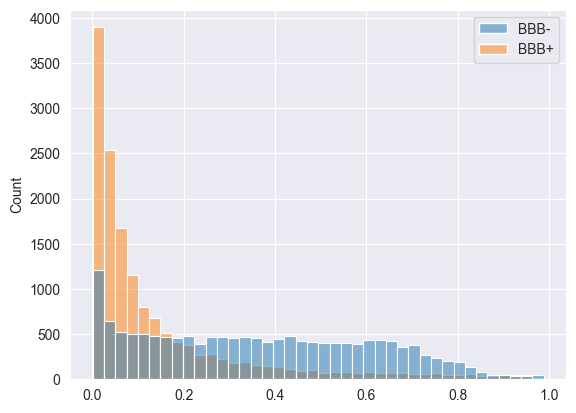

In [62]:
sns.histplot(df[["predicted_significance_BBB-", "predicted_significance_BBB+"]].rename(columns={"predicted_significance_BBB-": "BBB-", "predicted_significance_BBB+": "BBB+"}),)